<a href="https://colab.research.google.com/github/ANTRIKSH-GANJOO/pytorch_research/blob/main/Train%26Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:11<00:00, 15265178.00it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Data Check
Now Data has been loaded on our machine
checking data

In [5]:
import matplotlib.pyplot as plt
import numpy as np

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


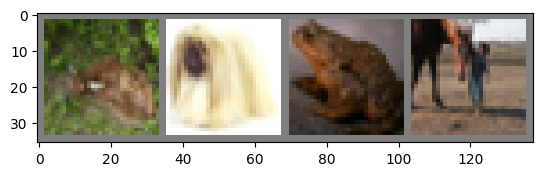

deer  dog   frog  horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


def ResNet18():

    return ResNet(ResidualBlock)

my_net = ResNet18()

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_net.to(device)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inp

In [9]:
# Loss Function Definition

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_net.parameters(), lr=0.001, momentum=0.9)

In [10]:
# Training the Neural Network
total = 0.0
correct = 0.0
running_loss = 0.0
num_epoch = 5
train_acc_list = []
test_acc_list = []
my_net.train()
for epoch in range(num_epoch):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # pushing to GPU
        # zero the parameter gradients
        #print("Check cuda", inputs.is_cuda)
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = my_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct // total
    train_acc_list.append(train_acc)
        #if i % 2000 == 1999:    # print every 2000 mini-batches
    print(f'[{epoch + 1}] Train loss: {running_loss / total:.3f}')
    print(f'Epoch: {epoch+1}, Train Accuracy: {100 * correct // total} %')

#print('Finished Training')

    total = 0.0
    correct = 0.0
    test_loss = 0.0
    my_net.eval()

    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # pushing to GPU
        # zero the parameter gradients
        #print("Check cuda", inputs.is_cuda)
        #optimizer.zero_grad()

        # forward + backward + optimize
            outputs = my_net(inputs)
            loss = criterion(outputs, labels)
        #loss.backward()
        #optimizer.step()

        # print statistics
            test_loss += loss.item()
        # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct // total
        test_acc_list.append(test_acc)
        #if i % 2000 == 1999:    # print every 2000 mini-batches
        print(f'[{epoch + 1}] Test loss: {test_loss / total:.3f}')
        print(f'Epoch: {epoch+1}, Test Accuracy: {100 * correct // total} %')

print('Finished Testing')

[1] Train loss: 0.349
Epoch: 1, Train Accuracy: 50.0 %
[1] Test loss: 0.236
Epoch: 1, Test Accuracy: 67.0 %


KeyboardInterrupt: 

In [ ]:
# print(len(train_acc_list))
# print(len(test_acc_list))

In [21]:
# total = 0.0
# correct = 0.0
# test_loss = 0.0
# test_acc_list = []
# my_net.eval()

# with torch.no_grad():
#     for i, data in enumerate(testloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device) # pushing to GPU
#         # zero the parameter gradients
#         #print("Check cuda", inputs.is_cuda)
#         #optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = my_net(inputs)
#         loss = criterion(outputs, labels)
#         #loss.backward()
#         #optimizer.step()

#         # print statistics
#         test_loss += loss.item()
#         # the class with the highest energy is what we choose as prediction
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     test_acc = 100 * correct // total
#     test_acc_list.append(test_acc)
#         #if i % 2000 == 1999:    # print every 2000 mini-batches
#     print(f'[{epoch + 1}] loss: {running_loss / total:.3f}')
#     print(f'Epoch: {epoch+1}, Test Accuracy: {100 * correct // total} %')

# print('Finished Testing')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[5] loss: 2.069
Epoch: 5, Test Accuracy: 82.0 %
Finished Testing


In [1]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epoch+1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, num_epoch+1), test_acc_list, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [3]:
torch.cuda.is_available()

True